# 1. Introduction

The objective of this study is to forecast monthly sales of Champagne, using the classic dataset published by **Makridakis and Wheelwright (1989)**. The series covers monthly sales from 1964 to 1972 and is characterized by:

- A **strong seasonal pattern**,  
- An **upward but fluctuating trend** over the years,  
- Relatively small size (less than 100 observations).

In the case description, a **baseline solution based on ARIMA** is provided. That approach handles non-stationarity by applying differencing and captures yearly seasonality with seasonal AR and MA terms.


## The Goal of This Notebook is:  

**Propose an alternative solution** that can better capture the evolving trend and seasonal structure of the series. We hypothesize that this approach will produce more realistic long-term forecasts and achieve a lower Root Mean Squared Error (RMSE) compared to the baseline ARIMA model. Moreover, reults of baseline ARIMA solution will be provided in the **3rd section of this notebook** in order to compare with the proposed solution. 

# Overview 

##### 1. Introduction 
##### 2. Environement and Dataset 
##### 3. Runing the code provided for ARIMA solution
##### 4. Solution Provided
##### 5. Possible Hybrid Model

# 2. Environement and Dataset 

In [158]:
# check the versions of key python libraries
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

scipy: 1.15.1
numpy: 1.24.3
matplotlib: 3.7.0
pandas: 1.5.3
statsmodels: 0.13.5
sklearn: 1.2.1


In [159]:
# separate out a validation dataset
from pandas import read_csv
series = read_csv('champagne.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 93, Validation 12


# 3. Runing the code provided for the baseline ARIMA solution

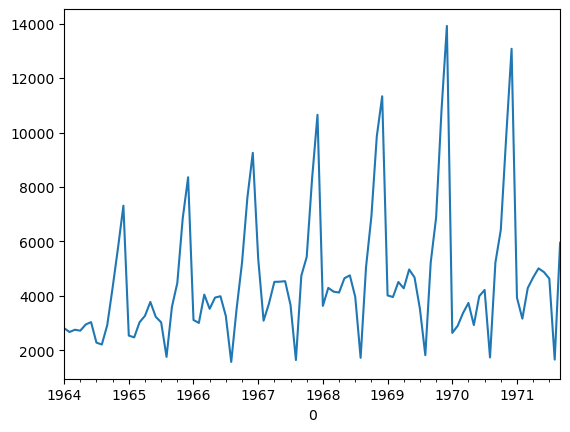

In [160]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
series.plot()
pyplot.show()

                 0
count    47.000000
mean   -204.270101
std     935.746185
min   -2325.393963
25%    -709.042279
50%    -228.936139
75%     333.614664
max    2191.022458


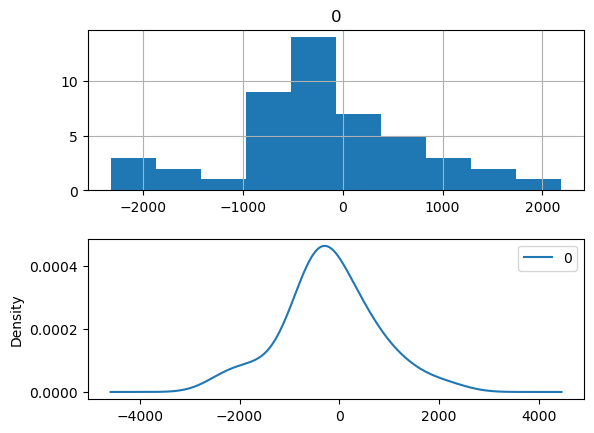

In [161]:
# summarize ARIMA forecast residuals
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

RMSE: 925.738
                  0
count  4.700000e+01
mean  -2.213730e-08
std    9.357462e+02
min   -2.121124e+03
25%   -5.047722e+02
50%   -2.466604e+01
75%    5.378848e+02
max    2.395293e+03


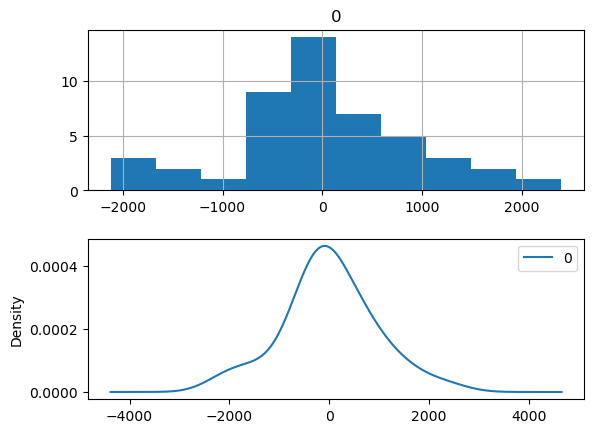

In [162]:
# plots of residual errors of bias corrected forecasts
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias =  -204.270101
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

In [163]:
# save finalized model
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(0,0,1))
model_fit = model.fit()
# bias constant, could be calculated from in-sample mean residual
bias = -204.270101
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

In [164]:
# load finalized model and make a prediction
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMAResults
import numpy

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 6633.903


>Predicted=6633.903, Expected=6981.000
>Predicted=9986.452, Expected=9851.000
>Predicted=13123.142, Expected=12670.000
>Predicted=3908.514, Expected=4348.000
>Predicted=3313.991, Expected=3564.000
>Predicted=4401.828, Expected=4577.000
>Predicted=4776.982, Expected=4788.000
>Predicted=5076.458, Expected=4618.000
>Predicted=4838.890, Expected=5312.000
>Predicted=4783.679, Expected=4298.000
>Predicted=1618.364, Expected=1413.000
>Predicted=5956.669, Expected=5877.000
RMSE: 335.291


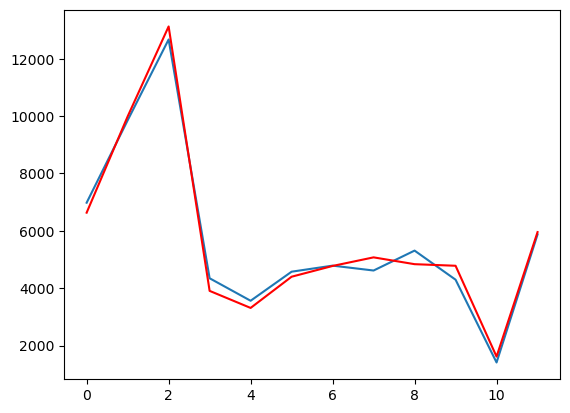

In [165]:
# load and evaluate the finalized model on the validation dataset
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load and prepare datasets
dataset = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

Some observations from the plot include:

- There may be an increasing trend of sales over time.
- There appears to be systematic seasonality to the sales for each year.
- The seasonal signal appears to be growing over time, suggesting a multiplicative relationship (increasing change).
- There do not appear to be any obvious outliers.
- The seasonality suggests that the series is almost certainly non-stationary.


The time series shows two key characteristics:

- **Seasonality**: Sales spike every December and fall sharply in January.  
- **Trend**: A generally upward but fluctuating trend across the years.  

These observations suggest that any effective forecasting model must handle both **trend** and **seasonality** explicitly.


## Baseline Results (from the tutorial code)

After observing the code and results provided in "https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/" :

| Data Split  | Method | RMSE     |
|-------------|--------|----------|
| Test        | ARIMA  | 924.699  |
| Validation  | ARIMA  | 361.110  |

Next, we will pursue a more precise approach using **Exponential Smoothing (ETS)**.


# 4. Solution Provided

## Exponential Smoothing (ETS) - Holt-Winters’ exponential smoothing

The ETS (Error, Trend, Seasonality) framework is a family of exponential smoothing methods used for time series forecasting.

ETS explicitly decomposes a series into three components:
- Error (E): Describes the randomness in the data. Can be additive (constant variance) or multiplicative (variance grows with the level).

- Trend (T): Captures the long-term progression of the series, which may be linear, exponential, damped, or absent.

- Seasonality (S): Models repeating patterns (e.g., monthly or yearly cycles), either additively (constant seasonal effect) or multiplicatively (seasonal effect grows with the level).

## ARIMA vs ETS for Champagne Sales Forecasting

| Aspect               | ARIMA (AutoRegressive Integrated Moving Average) | ETS (Error, Trend, Seasonality) |
|----------------------|--------------------------------------------------|---------------------------------|
| **Model focus**      | Captures autocorrelation, assumes (or enforces) stationarity | Directly models level, trend, and seasonality |
| **Seasonality**      | Requires SARIMA extension to capture seasonality | Handles additive/multiplicative seasonality natively |
| **Trend handling**   | Limited, must be differenced explicitly          | Flexible, built-in trend component |
| **Data requirements**| Works best on stationary data                    | Does not require stationarity |
| **Strengths**        | Strong baseline, widely used in forecasting      | Naturally suited for seasonal & trending data |
| **Limitations**      | Struggles with sudden spikes, preprocessing needed | Less emphasis on autocorrelation structure |
| **Best suited for**  | Short-term, stationary or weakly seasonal series | Strongly seasonal data like champagne sales |



## Why ETS is More Suitable for Champagne Sales Forecasting

ETS models are specifically designed to account for level, trend, and seasonality components directly. This makes them naturally suited for data like champagne sales. Meanwhile, Standard ARIMA requires explicit seasonal differencing or extension to SARIMA to capture some of these patterns. To resume, ARIMA assumes stationarity, but champagne sales clearly show strong seasonality and trends, while ETS handles **trend and seasonality directly** with built-in components. 

### Grid Search to Identify Configurations
We applied Holt-Winters exponential smoothing (within the ETS framework) and used grid search with walk-forward validation to identify the best combination of trend, damped trend, and seasonality specification

In [166]:
# ETS grid-search, export best model, then save chosen bias (additive or multiplicative)
import warnings, json, pickle
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas import read_csv, DataFrame
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from pathlib import Path


# Loading the data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values.astype('float64')
idx = series.index
train_size = int(len(X) * 0.50)
train, test = X[:train_size], X[train_size:]
m = 12  # monthly seasonality


# Hyperparameter grids
trend_options    = ['add', None]
seasonal_options = ['mul', 'add']
damped_options   = [True, False]
init_options     = ['estimated', 'heuristic']

def walk_forward_rmse(train_array, test_array, trend, seasonal, damped, init_method, m=12):
    """Walk-forward 1-step ahead ETS (Holt-Winters) over test_array."""
    hist = [float(x) for x in train_array]
    preds = []
    for i in range(len(test_array)):
        use_damped = bool(damped and (trend is not None))
        model = ExponentialSmoothing(
            hist,
            trend=trend,
            damped_trend=use_damped,
            seasonal=seasonal,
            seasonal_periods=m,
            initialization_method=init_method
        )
        fit = model.fit(optimized=True, use_brute=True)
        yhat = float(fit.forecast(1)[0])
        preds.append(yhat)
        hist.append(float(test_array[i]))
    rmse = sqrt(mean_squared_error(test_array, preds))
    return rmse, preds

# Grid search on (train -> test)
results = []
for trend in trend_options:
    for seasonal in seasonal_options:
        for damped in damped_options:
            if damped and trend is None:
                continue  # invalid combo
            for init_method in init_options:
                try:
                    rmse, preds = walk_forward_rmse(train, test, trend, seasonal, damped, init_method, m)
                    results.append({
                        "trend": trend,
                        "seasonal": seasonal,
                        "damped": damped,
                        "init": init_method,
                        "rmse": rmse,
                        "preds": preds
                    })
                    print(f"RMSE (ETS, trend={trend}, seasonal={seasonal}, damped={damped}, init={init_method}): {rmse:.3f}")
                except Exception:
                    pass

if not results:
    raise RuntimeError("No ETS configuration could be fit successfully.")

best = min(results, key=lambda r: r["rmse"])
print("\nBest configuration on test:")
print(f"trend={best['trend']}, seasonal={best['seasonal']}, damped={best['damped']}, init={best['init']}, RMSE={best['rmse']:.3f}")


# Estimate bias on TEST predictions
test_arr   = np.asarray(test, dtype=float)
preds_test = np.asarray(best["preds"], dtype=float)

bias_add = float(np.mean(test_arr - preds_test))                     # additive bias
eps = 1e-8
bias_mul = float(np.mean(test_arr / np.maximum(eps, preds_test)))    # multiplicative factor

rmse_add = sqrt(mean_squared_error(test_arr, preds_test + bias_add))
rmse_mul = sqrt(mean_squared_error(test_arr, preds_test * bias_mul))

if rmse_add <= rmse_mul:
    bias_type  = "add"
    bias_value = bias_add
    rmse_adj   = rmse_add
else:
    bias_type  = "mul"
    bias_value = bias_mul
    rmse_adj   = rmse_mul

print(f"Chosen bias on TEST -> type={bias_type}, value={bias_value:.6f}, "
      f"RMSE raw={best['rmse']:.3f} -> adjusted={rmse_adj:.3f}")


# Refitring best model on ALL dataset.csv, then save

full_history = X.tolist()
use_damped = bool(best["damped"] and (best["trend"] is not None))
final_model = ExponentialSmoothing(
    full_history,
    trend=best["trend"],
    damped_trend=use_damped,
    seasonal=best["seasonal"],
    seasonal_periods=m,
    initialization_method=best["init"]
).fit(optimized=True, use_brute=True)

Path("models").mkdir(exist_ok=True)
with open("models/ets_best.pkl", "wb") as f:
    pickle.dump(final_model, f)
# Save config + bias info  as JSON
cfg = {
    "trend": best["trend"],
    "seasonal": best["seasonal"],
    "damped": best["damped"],
    "init": best["init"],
    "m": m,
    # save chosen bias info 
    "bias_type": bias_type,          # "add" or "mul"
    "bias_value": float(bias_value)  # number of bias to apply
}
with open("models/ets_best_config.json", "w") as f:
    json.dump(cfg, f, indent=2)

# Saving a simple .npy for the bias value too
np.save("models/ets_best_bias.npy", np.array([bias_value], dtype=float))

print("\nSaved model to models/ets_best.pkl, config+bias to models/ets_best_config.json and models/ets_best_bias.npy")


RMSE (ETS, trend=add, seasonal=mul, damped=True, init=estimated): 889.786
RMSE (ETS, trend=add, seasonal=mul, damped=True, init=heuristic): 889.786
RMSE (ETS, trend=add, seasonal=mul, damped=False, init=estimated): 829.014
RMSE (ETS, trend=add, seasonal=mul, damped=False, init=heuristic): 829.014
RMSE (ETS, trend=add, seasonal=add, damped=True, init=estimated): 962.761
RMSE (ETS, trend=add, seasonal=add, damped=True, init=heuristic): 962.761
RMSE (ETS, trend=add, seasonal=add, damped=False, init=estimated): 978.984
RMSE (ETS, trend=add, seasonal=add, damped=False, init=heuristic): 978.984
RMSE (ETS, trend=None, seasonal=mul, damped=False, init=estimated): 860.228
RMSE (ETS, trend=None, seasonal=mul, damped=False, init=heuristic): 860.228
RMSE (ETS, trend=None, seasonal=add, damped=False, init=estimated): 975.849
RMSE (ETS, trend=None, seasonal=add, damped=False, init=heuristic): 975.849

Best configuration on test:
trend=add, seasonal=mul, damped=False, init=estimated, RMSE=829.014
Cho

As seen in the results obtained from the code above best configs on test are: **trend=add, seasonal=mul, damped=False, init=estimated**

The bias chosen is **50.696551** , and with the adjusted bias control we obtain RMSE=827.462

Let's validate our model 

Loaded config: {'trend': 'add', 'seasonal': 'mul', 'damped': False, 'init': 'estimated', 'm': 12, 'bias_type': 'add', 'bias_value': 50.696550918385235}
>Predicted=7181.831, Expected=6981.000
>Predicted=10864.753, Expected=9851.000
>Predicted=13854.744, Expected=12670.000
>Predicted=4096.848, Expected=4348.000
>Predicted=3715.387, Expected=3564.000
>Predicted=4571.757, Expected=4577.000
>Predicted=4860.619, Expected=4788.000
>Predicted=4972.627, Expected=4618.000
>Predicted=5159.115, Expected=5312.000
>Predicted=4780.243, Expected=4298.000
>Predicted=1989.251, Expected=1413.000
>Predicted=5993.262, Expected=5877.000
RMSE: 523.627


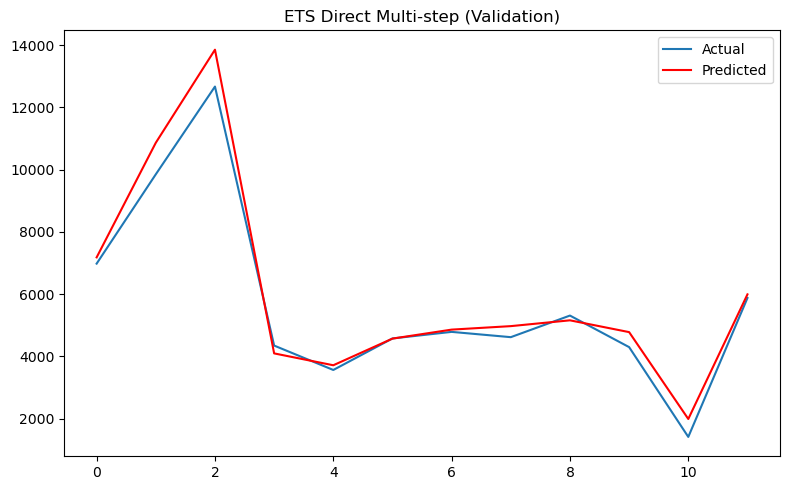

>Predicted=7181.831, Expected=6981.000
>Predicted=10883.565, Expected=9851.000
>Predicted=13666.462, Expected=12670.000
>Predicted=4130.599, Expected=4348.000
>Predicted=3788.438, Expected=3564.000
>Predicted=4560.464, Expected=4577.000
>Predicted=4814.292, Expected=4788.000
>Predicted=4974.659, Expected=4618.000
>Predicted=5117.504, Expected=5312.000
>Predicted=4664.452, Expected=4298.000
>Predicted=2031.546, Expected=1413.000
>Predicted=5813.062, Expected=5877.000
RMSE: 490.244


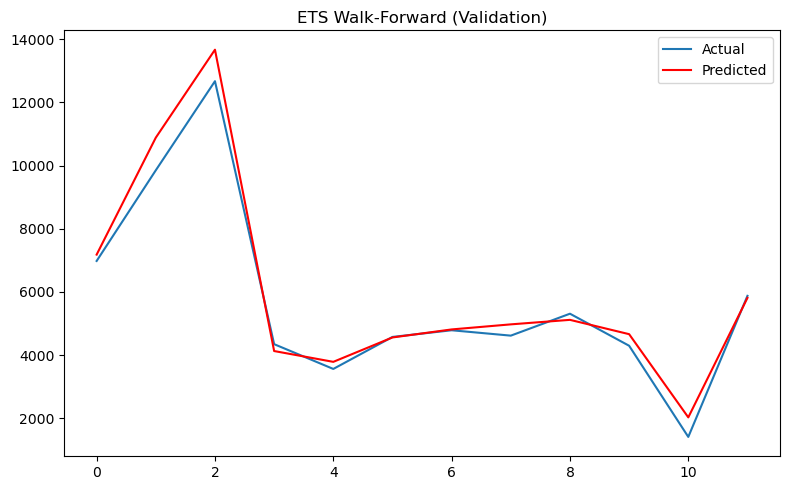

In [167]:
# Evaluatimg the saved model on validation.csv 
import warnings, json, pickle
warnings.filterwarnings("ignore")

import numpy as np
from pandas import read_csv, DataFrame
from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Loading saved model and configs 
with open("models/ets_best.pkl", "rb") as f:
    loaded_model = pickle.load(f)
with open("models/ets_best_config.json", "r") as f:
    cfg = json.load(f)

print("Loaded config:", cfg)

# Load data ==> full dataset ==> history + validation
train_series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
val_series   = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

full_history = train_series.values.astype('float64').tolist()
val_vals     = val_series.values.astype('float64').tolist()
val_idx      = val_series.index

# Bias helper (applies the bias learned on TEST) 
def apply_bias(arr, cfg):
    a = np.asarray(arr, dtype=float)
    btype = cfg.get("bias_type")
    bval  = cfg.get("bias_value")
    if btype == "add" and bval is not None:
        return a + float(bval)
    if btype == "mul" and bval is not None:
        return a * float(bval)
    return a  # no bias saved

# Walk-forward forecaster 
def walk_forward_with_config(initial_history, target, cfg):
    preds = []
    hist = list(map(float, initial_history))
    for i in range(len(target)):
        model = ExponentialSmoothing(
            hist,
            trend=cfg["trend"],
            damped_trend=bool(cfg["damped"] and (cfg["trend"] is not None)),
            seasonal=cfg["seasonal"],
            seasonal_periods=int(cfg["m"]),
            initialization_method=cfg["init"]
        )
        fit = model.fit(optimized=True, use_brute=True)
        preds.append(float(fit.forecast(1)[0]))
        hist.append(float(target[i]))
    return preds

# Pretty printer + plot 
def report_and_plot(y, predictions, title=None):
    for p, e in zip(predictions, y):
        print(f">Predicted={p:.3f}, Expected={float(e):.3f}")
    rmse = sqrt(mean_squared_error(y, predictions))
    print(f"RMSE: {rmse:.3f}")
    plt.figure(figsize=(8,5))
    plt.plot(y, label="Actual")
    plt.plot(predictions, color="red", label="Predicted")
    if title: plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

# Option 1: Direct multi-step forecast using the loaded fitted model
n_steps = len(val_vals)
multi_forecast_raw = loaded_model.forecast(n_steps)
multi_forecast = apply_bias(multi_forecast_raw, cfg)
report_and_plot(val_vals, multi_forecast, title="ETS Direct Multi-step (Validation)")

# Option 2: Walk-forward (1-step) using the saved CONFIG; bias applied AFTER forecasting 
preds_wf_raw = walk_forward_with_config(full_history, val_vals, cfg)
preds_wf = apply_bias(preds_wf_raw, cfg)
report_and_plot(val_vals, preds_wf, title="ETS Walk-Forward (Validation)")


With walk-forward validation we obtain **RMSE: 490.244**. This is mainly due to walk-forward method resets each step by refitting with the newest actual, so bias and drift are continually corrected. Meanwhile, multi-step assumes past parameters/states stay valid and produces the entire validation horizon in a single shot. Therefore walk-forward approach provides better results compared to direct multi-step.

- Direct multi-step ==> fit once on all pre-validation data
- Walk-forward (rolling one-step) ==> expanding window where we forecast one step ahead for t and append the actual y_t to history

# Final Results 

| Data Split  | Method | RMSE     |
|-------------|--------|----------|
| Test        | ARIMA  | 925.738  |
| Validation  | ARIMA  | 335.291  |
| Test        | ETS    | 827.462  |
| Validation  | ETS    | 490.244  |

# 5. Possible Hybrid Model

## Proposal: Hybrid ARIMA + ETS for Monthly Champagne Sales

We evaluated two strong univariate forecasters on the Champagne sales series (Makridakis & Wheelwright, 1989):
1. seasonal ARIMA with seasonal differencing and bias correction, and
2. seasonal ETS (Holt–Winters) via walk-forward re-estimation.

On our setup, ARIMA performs best on the validation window while ETS performs better on the test result. ETS is competitive but weaker. Because the two models capture complementary structure (serial correlation vs. level/seasonality dynamics), we combine them in a manner that chooses a weight **𝑤** to minimize RMSE on the validation set.



## My Porposition is Basically: 

1.Hybrid prediction (per time t):

- y_hat_hybrid[t] = w * y_hat_ETS[t] + (1 - w) * y_hat_ARIMA[t]

2. Constraint on the weight:
- 0 <= w <= 1

3. How we choose w:
- Pick the w that minimizes RMSE on the validation set as our ETS model preforms well on test but fails on validation data

ARIMA >Predicted=6633.903, Expected=6981.000
ARIMA >Predicted=9986.452, Expected=9851.000
ARIMA >Predicted=13123.142, Expected=12670.000
ARIMA >Predicted=3908.514, Expected=4348.000
ARIMA >Predicted=3313.991, Expected=3564.000
ARIMA >Predicted=4401.828, Expected=4577.000
ARIMA >Predicted=4776.982, Expected=4788.000
ARIMA >Predicted=5076.458, Expected=4618.000
ARIMA >Predicted=4838.890, Expected=5312.000
ARIMA >Predicted=4783.679, Expected=4298.000
ARIMA >Predicted=1618.364, Expected=1413.000
ARIMA >Predicted=5956.669, Expected=5877.000
ARIMA RMSE: 335.291
ETS RMSE: 490.244

ARIMA RMSE: 335.291
ETS RMSE: 490.244
Ensemble RMSE: 331.989  (w=0.12 on ETS)
>Predicted=6699.654, Expected=6981.000
>Predicted=10094.106, Expected=9851.000
>Predicted=13188.340, Expected=12670.000
>Predicted=3935.165, Expected=4348.000
>Predicted=3370.925, Expected=3564.000
>Predicted=4420.864, Expected=4577.000
>Predicted=4781.460, Expected=4788.000
>Predicted=5064.242, Expected=4618.000
>Predicted=4872.324, Expec

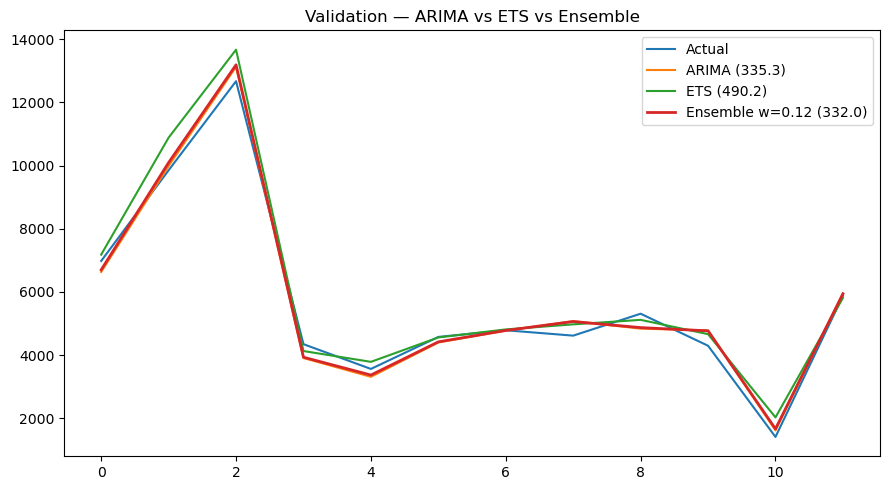

In [168]:
# === ARIMA (your implementation) + ETS (walk-forward) + BLEND on validation.csv ===
import warnings, json, inspect
warnings.filterwarnings("ignore")

import numpy as np
from pandas import read_csv
from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as pyplot
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Helpers 
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        diff.append(dataset[i] - dataset[i - interval])
    return diff

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# Load & prepare datasets
dataset    = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X          = dataset.values.astype('float32')
history    = [x for x in X]     # expanding history (original scale)
months_in_year = 12

validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y          = validation.values.astype('float32')

# A) ARIMA: load your saved model + bias
arima_fit = ARIMAResults.load('model.pkl')
bias      = float(np.load('model_bias.npy')[0])

arima_preds = []

yhat = float(arima_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
arima_preds.append(yhat)
history.append(float(y[0]))
print('ARIMA >Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))

for i in range(1, len(y)):
    diff_hist = difference(history, months_in_year)
    model     = ARIMA(diff_hist, order=(0,0,1))
    arima_fit = model.fit()
    yhat      = float(arima_fit.forecast()[0])
    yhat      = bias + inverse_difference(history, yhat, months_in_year)
    arima_preds.append(yhat)
    obs = float(y[i])
    history.append(obs)
    print('ARIMA >Predicted=%.3f, Expected=%.3f' % (yhat, obs))

rmse_arima = sqrt(mean_squared_error(y, arima_preds))
print('ARIMA RMSE: %.3f' % rmse_arima)

# B) ETS: load saved config and walk-forward on validation 
def apply_bias(arr, cfg):
    a = np.asarray(arr, dtype=float)
    if not cfg:
        return a
    btype = cfg.get("bias_type")
    bval  = cfg.get("bias_value")
    if btype == "add" and bval is not None: return a + float(bval)
    if btype == "mul" and bval is not None: return a * float(bval)
    return a

try:
    with open("models/ets_best_config.json", "r") as f:
        ets_cfg = json.load(f)
except Exception:
    ets_cfg = {"trend":"add","seasonal":"mul","damped":False,"init":"estimated","m":12}

def _fit_hw(hist, trend, seasonal, damped, init_m, m, use_boxcox, remove_bias):
    """Fit HW handling statsmodels API differences (init vs fit kwargs)."""
    init_params = set(inspect.signature(ExponentialSmoothing.__init__).parameters.keys())
    fit_params  = set(inspect.signature(ExponentialSmoothing.fit).parameters.keys())

    kwargs_init = dict(
        trend=trend,
        damped_trend=bool(damped and (trend is not None)),
        seasonal=seasonal,
        seasonal_periods=m,
        initialization_method=init_m,
    )
    kwargs_fit = dict(optimized=True, use_brute=True)

    if use_boxcox is not None:
        if 'use_boxcox' in init_params: kwargs_init['use_boxcox'] = use_boxcox
        elif 'use_boxcox' in fit_params: kwargs_fit['use_boxcox'] = use_boxcox
    if remove_bias is not None:
        if 'remove_bias' in init_params: kwargs_init['remove_bias'] = bool(remove_bias)
        elif 'remove_bias' in fit_params: kwargs_fit['remove_bias'] = bool(remove_bias)

    model = ExponentialSmoothing(hist, **kwargs_init)
    return model.fit(**kwargs_fit)

def walk_forward_ets(initial_history, target, cfg):
    preds = []
    hist = list(map(float, initial_history))
    trend    = cfg.get("trend", "add")
    seasonal = cfg.get("seasonal", "mul")
    damped   = cfg.get("damped", False)
    init_m   = cfg.get("init", "estimated")
    m        = int(cfg.get("m", 12))
    use_boxcox  = cfg.get("use_boxcox", None)
    remove_bias = cfg.get("remove_bias", None)
    
    for i in range(len(target)):
        init_used = init_m
        if init_used == 'heuristic' and seasonal is not None and len(hist) < 2*m:
            init_used = 'estimated'
        fit = _fit_hw(hist, trend, seasonal, damped, init_used, m, use_boxcox, remove_bias)
        preds.append(float(fit.forecast(1)[0]))
        hist.append(float(target[i]))
    return np.asarray(preds, dtype=float)

ets_history = dataset.values.astype('float64').tolist()
ets_preds_raw = walk_forward_ets(ets_history, y, ets_cfg)
ets_preds = apply_bias(ets_preds_raw, ets_cfg)
rmse_ets = sqrt(mean_squared_error(y, ets_preds))
print('ETS RMSE: %.3f' % rmse_ets)

# C) Blend: best w in [0,1] minimizing
ws = np.linspace(0.0, 1.0, 101)
def rmse(y_true, y_hat): return sqrt(mean_squared_error(y_true, y_hat))
best = min(((w, rmse(y, w*ets_preds + (1-w)*np.asarray(arima_preds, dtype=float))) for w in ws),
           key=lambda t: t[1])
w_best, rmse_best = best
blend = w_best*ets_preds + (1-w_best)*np.asarray(arima_preds, dtype=float)


# RMSE summary 

print(f"\nARIMA RMSE: {rmse_arima:.3f}")
print(f"ETS RMSE: {rmse_ets:.3f}")
print(f"Ensemble RMSE: {rmse_best:.3f}  (w={w_best:.2f} on ETS)")

# Per-step lines and plot
for p, e in zip(blend, y):
    print(f">Predicted={float(p):.3f}, Expected={float(e):.3f}")
print("RMSE: %.3f" % rmse_best)

pyplot.figure(figsize=(9,5))
pyplot.plot(y, label="Actual")
pyplot.plot(arima_preds, label=f"ARIMA ({rmse_arima:.1f})")
pyplot.plot(ets_preds, label=f"ETS ({rmse_ets:.1f})")
pyplot.plot(blend, label=f"Ensemble w={w_best:.2f} ({rmse_best:.1f})", linewidth=2)
pyplot.title("Validation — ARIMA vs ETS vs Ensemble")
pyplot.legend(); pyplot.tight_layout(); pyplot.show()


## Final Results on Validation Set
| Model                | RMSE     |
|----------------------|----------|
| ARIMA                | 335.291  |
| ETS (Holt–Winters)   | 490.244  |
| ARIMA + ETS (w=0.xx) | 331.989  |


Complementary strengths:

- ARIMA excels at short-term autocorrelation and the seasonal differencing captures the annual pattern;

- ETS naturally models level/trend and multiplicative seasonal amplitude, such as peak months.

# 6. Conclusion

**!!!** **Best single model**: **ARIMA (RMSE 335.291)** outperforms **ETS (RMSE 490.244)** on the Champagne validation set.

**!!!** **Hybrid win**: A simple **ARIMA + ETS** blend improves **RMSE to 331.989**.

##### ARIMA captures short-term autocorrelation and seasonal differencing well, and ETS contributes complementary signal on level/seasonal amplitude. 


## Next steps
More hybrid models as :

- STL (on log scale) + SARIMA on remainder 
- Other blends with ETS 

**can be explored !!!**
